<a href="https://colab.research.google.com/github/hk1997/quant-finance/blob/main/simple_momentum_trading_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Principle
* Assets which have performed well in the past will continue to perform well in the near future (and vce versa for underperformers).
* Focus on identifying and riding the wave of price trends - whether uptrends or downtrends.

### Building dataset for analysis
* Install yfinance library to fetch stock tickers.
* Download data for a period of time and group by ticker symbol.

In [2]:
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd

tickers = ['AAPL', 'MSFT', 'TSLA', 'GOOG', 'NVDA']

# Download full data with group_by ticker
data = yf.download(tickers, start="2023-01-01", end="2024-01-01", group_by='ticker', auto_adjust=True)

# Extract just the 'Close' prices
close_prices = pd.concat([data[ticker]['Close'] for ticker in tickers], axis=1)
close_prices.columns = tickers

[*********************100%***********************]  5 of 5 completed


In [3]:
close_prices.head()

,AAPL,MSFT,TSLA,GOOG,NVDA
Date,,,,,
2023-01-03,123.470612,234.808945,108.099998,89.169960,14.302284
2023-01-04,124.744118,224.537674,113.639999,88.185806,14.735901
2023-01-05,123.421249,217.882843,110.339996,86.257263,14.252332
2023-01-06,127.962456,220.450699,113.059998,87.639061,14.845804
2023-01-09,128.485641,222.597076,119.769997,88.275284,15.614121


In [4]:
returns = close_prices.pct_change().dropna()

In [5]:
returns.head()

,AAPL,MSFT,TSLA,GOOG,NVDA
Date,,,,,
2023-01-04,0.010314,-0.043743,0.051249,-0.011037,0.030318
2023-01-05,-0.010605,-0.029638,-0.029039,-0.021869,-0.032816
2023-01-06,0.036794,0.011785,0.024651,0.016019,0.041640
2023-01-09,0.004089,0.009736,0.059349,0.007260,0.051753
2023-01-10,0.004456,0.007617,-0.007681,0.004955,0.017980


### Momentum score computation

* We are computing the momentum score as the percentage return over a fixed lookback period.

### 📈 Momentum Score Formula

Let:

- \( P_t \) = price at time \( t \) (current)
- \( P_{t - n} \) = price at time \( t - n \) (n days ago)
- \( n \) = lookback period

Then the **momentum score** is calculated as:

$$
\text{Momentum Score} = \frac{P_t - P_{t - n}}{P_{t - n}} = \left( \frac{P_t}{P_{t - n}} \right) - 1
$$

This gives the **percentage return over the last \( n \) days**, and is used to rank assets for momentum-based trading strategies.

In pandas, pct_change function already implements the functionaly of percentage change over a period.

In [11]:
lookback = 20
momentum_scores = data.pct_change(periods=lookback).dropna()

In [7]:
momentum_scores.head()

Ticker          NVDA                                              AAPL  \
Price           Open      High       Low     Close    Volume      Open   
Date                                                                     
2023-02-01  0.325904  0.413177  0.391246  0.463011  0.645938  0.105081   
2023-02-02  0.441615  0.477749  0.453550  0.471896  0.308242  0.173457   
2023-02-03  0.449175  0.493065  0.469395  0.479145  0.103292  0.164399   
2023-02-06  0.437474  0.437042  0.481117  0.419275  0.116415  0.210777   
2023-02-07  0.398979  0.386335  0.396869  0.418799  0.317154  0.154595   

Ticker                                              ...      TSLA            \
Price           High       Low     Close    Volume  ...      Open      High   
Date                                                ...                       
2023-02-01  0.120015  0.138117  0.162789 -0.307302  ...  0.467798  0.547222   
2023-02-02  0.175035  0.184602  0.193574  0.327957  ...  0.716891  0.716991   
2023-02-03  0.231745  0.184915  0.235802  0.906524  ...  0.664555  0.780761   
2023-02-06  0.175071  0.207302  0.170575 -0.203937  ...  0.873883  0.732407   
2023-02-07  0.163556  0.159751  0.188244  0.177026  ...  0.651227  0.598931   

Ticker                                        GOOG                      \
Price            Low     Close    Volume      Open      High       Low   
Date                                                                     
2023-02-01  0.623949  0.678168 -0.076043  0.110319  0.116221  0.105594   
2023-02-02  0.698382  0.656723  0.205441  0.173388  0.192679  0.213440   
2023-02-03  0.714166  0.721769  0.472672  0.175315  0.224578  0.193392   
2023-02-06  0.865436  0.722625 -0.157181  0.175424  0.183452  0.194461   
2023-02-07  0.618564  0.643233 -0.022460  0.161836  0.196411  0.168977   

Ticker                          
Price          Close    Volume  
Date                            
2023-02-01  0.130769  0.272638  
2023-02-02  0.226468  0.723794  
2023-02-03  0.212631  0.591599  
2023-02-06  0.173662 -0.039064  
2023-02-07  0.216667  0.467115  

[5 rows x 25 columns]

In [8]:
def get_momentum_portfolio(momentum_scores, top_n=1):
    latest_scores = momentum_scores.iloc[-1]
    top = latest_scores.nlargest(top_n).index
    bottom = latest_scores.nsmallest(top_n).index
    return top, bottom


In [9]:
hold_period = 5
top, bottom = get_momentum_portfolio(momentum_scores)

future_returns = data.pct_change(periods=hold_period).shift(-hold_period).dropna()

portfolio_return = future_returns[top].mean(axis=1) - future_returns[bottom].mean(axis=1)


<Axes: title={'center': 'Momentum Strategy Return vs Time'}, xlabel='Date'>

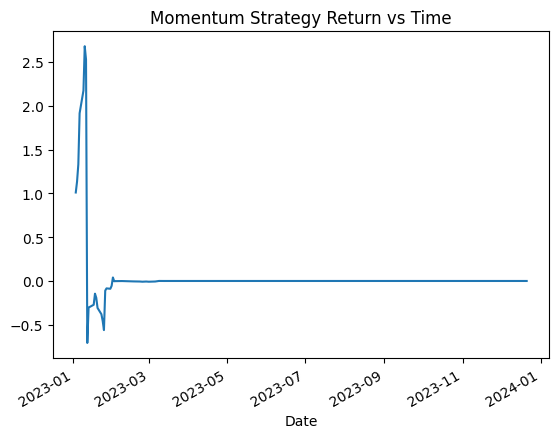

In [10]:
import matplotlib.pyplot as plt

cumulative_return = (1 + portfolio_return).cumprod()
cumulative_return.plot(title='Momentum Strategy Return vs Time')


In [16]:
def compute_sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    daily_sharpe = excess_returns.mean() / excess_returns.std()
    annualized_sharpe = daily_sharpe * (252 ** 0.5)
    return annualized_sharpe

sharpe = compute_sharpe_ratio(portfolio_return)
print(f"Momentum Strategy Sharpe Ratio: {sharpe:.2f}")


Momentum Strategy Sharpe Ratio: -1.72


In [18]:
spy = yf.download('SPY', start="2023-01-01", end="2024-01-01", auto_adjust=True)
spy_returns = spy['Close'].pct_change().dropna()

def compute_sharpe_ratio(returns, risk_free_rate=0.0):
    if isinstance(returns, pd.DataFrame):
        returns = returns.iloc[:, 0]  # use the first column
    excess_returns = returns - risk_free_rate
    daily_sharpe = excess_returns.mean() / excess_returns.std()
    annualized_sharpe = daily_sharpe * (252 ** 0.5)
    return annualized_sharpe

spy_sharpe = compute_sharpe_ratio(spy_returns)
print(f"SPY Sharpe Ratio: {spy_sharpe:.2f}")


[*********************100%***********************]  1 of 1 completed

SPY Sharpe Ratio: 1.90


## 📊 Sharpe Ratio Comparison: Momentum Strategy vs SPY

### ✅ What is Sharpe Ratio?

The **Sharpe Ratio** measures how much **excess return** a strategy generates **per unit of risk**. It helps answer:

> "Am I getting adequately rewarded for the risk I'm taking?"

Mathematically:

$$
\text{Sharpe Ratio} = \frac{\text{Average Return} - \text{Risk-Free Rate}}{\text{Standard Deviation of Returns}}
$$

We usually set the **risk-free rate to 0** for short-term backtests.

---

### 📈 Our Results:

| Strategy              | Sharpe Ratio |
|-----------------------|--------------|
| **Momentum Strategy** | -1.72        |
| **SPY (Buy & Hold)**  |  1.90        |

---

### 🔍 Interpretation

- **SPY Buy & Hold (Sharpe = 1.90)**:
  - This is a **very healthy** Sharpe ratio.
  - It means SPY gave **stable and consistent positive returns** with relatively low volatility.
  - Classic example of long-term investing in a broad market index.

- **Momentum Strategy (Sharpe = -1.72)**:
  - This is a **negative Sharpe ratio**, which is a major red flag.
  - It means the strategy was **losing money while being volatile**, i.e., high risk but no reward.
  - Likely due to:
    - Poor stock selection,
    - Lack of rebalancing,
    - Overreacting to short-term noise,
    - Or buying into short-term peaks and selling bottoms.

---

### 🧠 What This Tells Us

- Even though momentum is a widely used trading strategy, **naively applying it doesn't guarantee success**.
- The **Sharpe ratio helps compare performance in a fair way**, because it penalizes strategies that are erratic, even if they have high raw returns.
- In this case, our strategy would be considered **uninvestable**, while SPY is clearly **superior** from both return and risk perspectives.

---


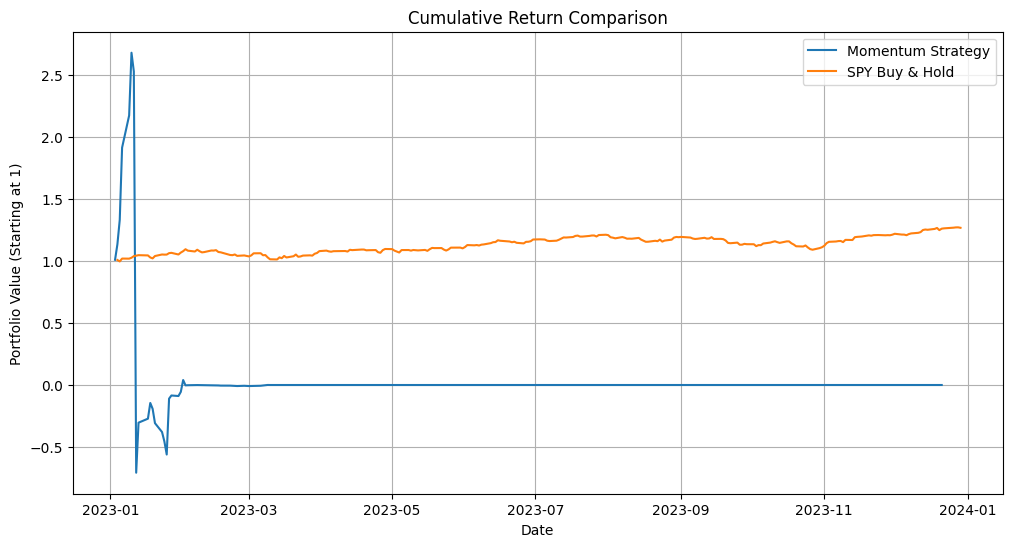

In [19]:
# Cumulative returns
strategy_cum = (1 + portfolio_return).cumprod()
spy_cum = (1 + spy_returns).cumprod()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(strategy_cum, label='Momentum Strategy')
plt.plot(spy_cum, label='SPY Buy & Hold')
plt.title("Cumulative Return Comparison")
plt.ylabel("Portfolio Value (Starting at 1)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()


## 📉 Cumulative Return Plot Analysis

This plot compares the **cumulative returns** of our **momentum strategy** (blue line) against a **buy-and-hold investment in SPY** (orange line), over the period from January 2023 to January 2024.

---

### 🔵 Momentum Strategy (Blue Line)

- The strategy shows a **sharp spike early on**, quickly jumping above 2.5× — suggesting an **unrealistically large gain** in the very first rebalance or trade.
- But immediately after, it **crashes below zero**, indicating a **major loss**.
- After this early volatility, the line **flatlines**, staying around zero or negative for the rest of the year.  
  This means the strategy **either lost all capital or stopped trading** effectively after the initial loss.


---

### 🟠 SPY Buy & Hold (Orange Line)

- Shows a **smooth, consistent upward slope** — exactly what we expect from an ETF that tracks the S&P 500.
- The growth is steady, reaching a cumulative return of ~1.3× by year-end.
- Indicates **stable, compounding gains** over time with **low volatility**.
